# Time Series Generative Adversarial Networks

In [1]:
# Pacakge Loading
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from training import build_and_train_models
from utils import create_latent
from data import data_loading
import numpy as np

2023-07-21 10:06:46.127380: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Data Preprocessing

proxy_price = pd.read_csv('ProxyAdjPrices.csv', index_col=0, parse_dates=True)
proxy_price.interpolate(method='linear', inplace=True)

# Cash: FTSE 3 Month T-Bill Index, US Equity: S&P 500 TR, US Bond: Bloomberg US Aggregate Bond Index, Real Asset: S&P RA TR, Emerging Market: M2EF Index, Commodities: Bloomberg Commodity TR
Proxy_col=['SBMMTB3 Index', 'ACWI US Equity', 'LBUSTRUU Index', 'FNRETR Index', 'M2EF Index', 'BCOMTR Index']
data = proxy_price.loc[:, Proxy_col]
data = data.loc['2013-01-01':'2018-12-31', :] # return was not used as series directly since the original paper has one feature highly relient on return. Return was incorporated in the feature engineering process. Also, test and train split is performed in the main function.



In [3]:
# Model Building
seq_length = 24 #specifying the length of series, multiple of 2 to make the reshape work
features_n = 6 #specifying the number of features
noise_dim = seq_length * features_n #specifying the dimension of noise vector
SHAPE = (seq_length, features_n) #specifying the shape of input data
hidden_dim = features_n * 4 #specifying the dimension of hidden layer

# todo: fine tune the hyperparameters & model structure
# todo: interest rates, basic marcos, inflation, etc.

"""
the original model used 2000 steps, here I just load a small number of steps
to highlight the process, and get the model architecture
"""
steps = 100 # original model used 2000
gen0, gen1 = build_and_train_models(data = data, train_steps = steps, seq_length= seq_length, SHAPE= SHAPE)

# Comment and uncomment to save models
# gen1.save("gen0")
# gen0.save_weights("gen1_weights")

(array([1, 2, 3, 4, 5]), array([ 80, 902, 461,  89,   9]))
dataX.shape: (1541, 24, 7)
y.shape: (1541,)
y_train.shape: (1078, 6)
y_test.shape: (463, 6)
Model: "dis0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 discriminator0_input (InputLay  [(None, 144)]       0           []                               
 er)                                                                                              
                                                                                                  
 dense (Dense)                  (None, 144)          20880       ['discriminator0_input[0][0]']   
                                                                                                  
 dense_1 (Dense)                (None, 144)          20880       ['dense[0][0]']                  
                                           

/Users/huyifei/anaconda3/envs/GAN310/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2023-07-21 10:07:03.486450: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 discriminator1_input (InputLay  [(None, 24, 6)]     0           []                               
 er)                                                                                              
                                                                                                  
 gru (GRU)                      (None, 144)          65664       ['discriminator1_input[0][0]']   
                                                                                                  
 reshape (Reshape)              (None, 12, 12)       0           ['gru[0][0]']                    
                                                                                                  
 conv1d (Conv1D)                (None, 6, 16)        592         ['reshape[0][0]']    

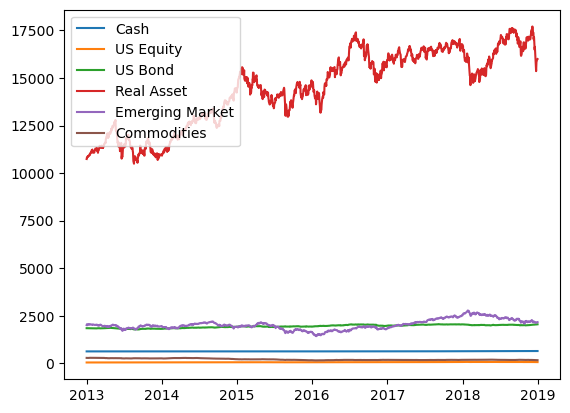

In [4]:
# Data Visualization
plt.plot(data['SBMMTB3 Index'], label='Cash')
plt.plot(data['ACWI US Equity'], label='US Equity')
plt.plot(data['LBUSTRUU Index'], label='US Bond')
plt.plot(data['FNRETR Index'], label='Real Asset')
plt.plot(data['M2EF Index'], label='Emerging Market')
plt.plot(data['BCOMTR Index'], label='Commodities')
plt.legend(loc='upper left')

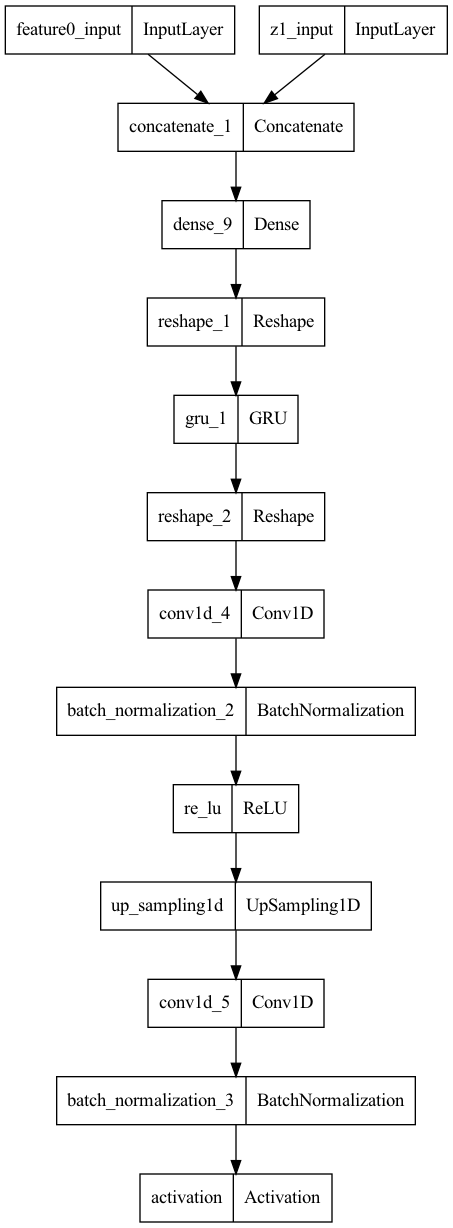

In [5]:
# Model Visualization
tf.keras.utils.plot_model(
    gen1, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB'
)

In [6]:
# todo: conditional generation, more layers to parametrize the price processes

from utils import inverse_trans
d_recipe = {}
d_recipe["class0"] = [0, True, "Normal"]
d_recipe["class5"] = [5, True, "Normal"]
d_recipe["noise"] = [None, False, "Normal"]
d_recipe["z0_4"] = [None, False, "z0_4"]
d_recipe["z1_4"] = [None, False, "z1_4"]
d_recipe["org"] = d_recipe["noise"]

key = 'class0'
datax, _, scaler = data_loading(seq_length, data)


(array([1, 2, 3, 4, 5]), array([ 80, 902, 461,  89,   9]))


12/12 [==============================] - 1s 40ms/step
(365, 6)
<class 'numpy.ndarray'>


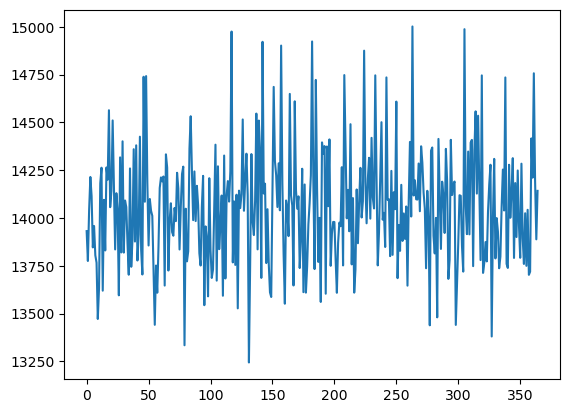

In [7]:
# Generating Synthetic Data via GAN
new, noise_class, z0, z1 = create_latent(dataX = datax,batch_n=365, class_label = None, classed=False, noise="Normal")
gen0.compile(run_eagerly=True)
gen1.compile(run_eagerly=True)
feature0 = gen0.predict([noise_class, z1])
gen_data = gen1.predict([feature0, z0])
gen_data_t = inverse_trans(train_data= gen_data, scaler= scaler)
print(gen_data_t[:,0,:].shape)
print(type(gen_data_t))
plt.plot(gen_data_t[:,0,3], label='Cash')

In [8]:
cov_gan = np.cov(gen_data_t[:,0,:].T)
corr_gan = np.corrcoef(gen_data_t[:,0,:].T)
print('covariance matrix implied by GAN \n')
print(cov_gan)
print('\n correlation matrix implied by GAN\n')
print(corr_gan)

covariance matrix implied by GAN 

[[ 1.70368422e+00 -9.72303667e-01  9.47869703e+00  6.18159755e+00
   5.11541105e+01  9.44371003e+00]
 [-9.72303667e-01  2.53809160e+00 -6.76866053e+00 -1.06434370e+01
   3.41352202e+01 -1.16642817e+01]
 [ 9.47869703e+00 -6.76866053e+00  6.67424414e+02  5.46595704e+03
   1.80721059e+03 -7.78852812e+00]
 [ 6.18159755e+00 -1.06434370e+01  5.46595704e+03  9.20945345e+04
   1.36642180e+04 -9.39342672e+02]
 [ 5.11541105e+01  3.41352202e+01  1.80721059e+03  1.36642180e+04
   1.07936466e+04  4.29049122e+01]
 [ 9.44371003e+00 -1.16642817e+01 -7.78852812e+00 -9.39342672e+02
   4.29049122e+01  1.90652380e+02]]

 correlation matrix implied by GAN

[[ 1.         -0.46757763  0.28109495  0.01560592  0.37722624  0.5239948 ]
 [-0.46757763  1.         -0.16445536 -0.02201463  0.20623623 -0.53025313]
 [ 0.28109495 -0.16445536  1.          0.69718533  0.67332326 -0.021834  ]
 [ 0.01560592 -0.02201463  0.69718533  1.          0.43339486 -0.2241744 ]
 [ 0.37722624  0.2062

In [9]:
# Generating Synthetic Data via Bootstrapping
from utils import bootstrap_from_historical
gen_data_b = bootstrap_from_historical(data, 365)
print(gen_data_b.shape)
cov_boot = np.cov(gen_data_b.T)
corr_boot = np.corrcoef(gen_data_b.T)
print('covariance matrix implied by Bootstrapping \n')
print(cov_boot)
print('\n correlation matrix implied by Bootstrapping \n')
print(corr_boot)

(365, 6)
covariance matrix implied by Bootstrapping 

[[ 2.12701287e+01  2.73190373e+01  2.05615687e+02  5.20056691e+03
   7.69463677e+02 -8.04313787e+01]
 [ 2.73190373e+01  5.53530646e+01  4.40209782e+02  1.11838961e+04
   1.54015489e+03 -1.78831931e+02]
 [ 2.05615687e+02  4.40209782e+02  6.02097224e+03  1.46719678e+05
   8.09059293e+03 -2.74338968e+03]
 [ 5.20056691e+03  1.11838961e+04  1.46719678e+05  3.81527139e+06
   1.82791337e+05 -6.87181407e+04]
 [ 7.69463677e+02  1.54015489e+03  8.09059293e+03  1.82791337e+05
   6.76048061e+04 -8.07989536e+02]
 [-8.04313787e+01 -1.78831931e+02 -2.74338968e+03 -6.87181407e+04
  -8.07989536e+02  1.65344322e+03]]

 correlation matrix implied by Bootstrapping 

[[ 1.          0.79617676  0.57456329  0.5773018   0.64167376 -0.42888989]
 [ 0.79617676  1.          0.76252755  0.76959027  0.79616811 -0.59112536]
 [ 0.57456329  0.76252755  1.          0.96803784  0.40101282 -0.8694799 ]
 [ 0.5773018   0.76959027  0.96803784  1.          0.35991845 -0.8

In [10]:
# covariance matrix implied by original data
cov_org = np.cov(data.T)
corr_org = np.corrcoef(data.T)
print('covariance matrix implied by original data \n')
print(cov_org)
print('\n correlation matrix implied by original data \n')
print(corr_org)


covariance matrix implied by original data 

[[ 2.28145690e+01  3.09478097e+01  2.22213881e+02  6.04931555e+03
   8.30388192e+02 -8.95893404e+01]
 [ 3.09478097e+01  5.99592301e+01  4.67603767e+02  1.22430817e+04
   1.64368497e+03 -1.89803966e+02]
 [ 2.22213881e+02  4.67603767e+02  6.15783786e+03  1.51545121e+05
   8.48132816e+03 -2.84986614e+03]
 [ 6.04931555e+03  1.22430817e+04  1.51545121e+05  4.01779043e+06
   2.07084313e+05 -7.11698192e+04]
 [ 8.30388192e+02  1.64368497e+03  8.48132816e+03  2.07084313e+05
   6.99337483e+04 -1.01203969e+03]
 [-8.95893404e+01 -1.89803966e+02 -2.84986614e+03 -7.11698192e+04
  -1.01203969e+03  1.70590413e+03]]

 correlation matrix implied by original data 

[[ 1.          0.83675007  0.59285833  0.63183905  0.65740292 -0.45412237]
 [ 0.83675007  1.          0.76954825  0.78880396  0.80268871 -0.59347161]
 [ 0.59285833  0.76954825  1.          0.96346112  0.4087016  -0.87929181]
 [ 0.63183905  0.78880396  0.96346112  1.          0.39067009 -0.85965642]


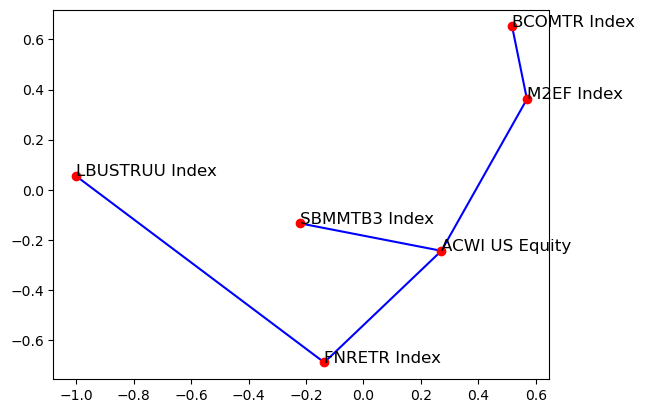

In [11]:
# Extracting Market Structure via MST from correlation matrix
# In this version, I will use the simple pearson correlation, while in later iterations, todo: ranked correlation will be tested for 1) stability of MST 2) implications for GAN training and portfolio construction

## Use index log return from 'Internship Data' as proxy for nodes.

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')

# Calculating pairwise correlation to construct a distance matrix
dist_matrix = 1 - data.corr()

# Creating a graph from the distance matrix
G = nx.from_pandas_adjacency(dist_matrix)

# Computing the minimum spanning tree (MST) of the graph
mst = nx.minimum_spanning_tree(G)

# Creating a spring layout for the MST
pos = nx.spring_layout(mst)

# Plotting the MST
fig, ax = plt.subplots()

# Draw the edges
for edge in mst.edges(data=True):
    node1, node2, _ = edge
    x_coords = [pos[node1][0], pos[node2][0]]
    y_coords = [pos[node1][1], pos[node2][1]]
    ax.plot(x_coords, y_coords, 'b-')

# Draw the nodes
for node in mst.nodes():
    ax.plot(pos[node][0], pos[node][1], 'ro')
    ax.text(pos[node][0], pos[node][1], str(node), fontsize=12)

plt.show()
